## Equally Weighted Risk Contributions Portfolio 

In [2]:
import sys
import os

sys.path.append(
    os.path.abspath(
        os.path.join(os.path.dirname(os.path.realpath("__file__")), "..", "..")
    )
)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bt

In [8]:
from bt.algos.weighting import WeighERC
from bt.algos.portfolio_ops import Rebalance
from bt.algos.selection import SelectThese
from bt.algos.flow import RunAfterDays
from bt.core import Strategy
from bt.engine import Backtest

### Create Fake Index Data

In [4]:
mean = np.array([0.05 / 252 + 0.02 / 252, 0.03 / 252 + 0.02 / 252])
volatility = np.array([0.2 / np.sqrt(252), 0.05 / np.sqrt(252)])
variance = np.power(volatility, 2)
correlation = np.array([[1, 0.25], [0.25, 1]])
covariance = np.zeros((2, 2))
for i in range(len(variance)):
    for j in range(len(variance)):
        covariance[i, j] = correlation[i, j] * volatility[i] * volatility[j]

covariance

array([[1.58730159e-04, 9.92063492e-06],
       [9.92063492e-06, 9.92063492e-06]])

<Axes: >

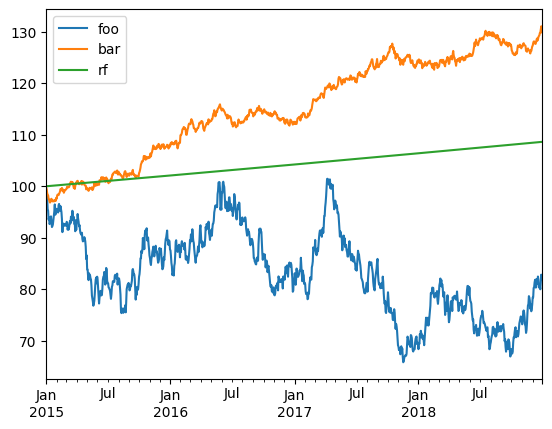

In [6]:
names = ["foo", "bar", "rf"]
dates = pd.date_range(
    start="2015-01-01", end="2018-12-31", freq=pd.tseries.offsets.BDay()
)
n = len(dates)
rdf = pd.DataFrame(np.zeros((n, len(names))), index=dates, columns=names)

np.random.seed(1)
rdf.loc[:, ["foo", "bar"]] = np.random.multivariate_normal(mean, covariance, size=n)
rdf["rf"] = 0.02 / 252

pdf = 100 * np.cumprod(1 + rdf)
pdf.plot()

### Build and run ERC Strategy

You can read more about ERC here.
http://thierry-roncalli.com/download/erc.pdf

In [10]:
runAfterDaysAlgo = RunAfterDays(20 * 6 + 1)

selectTheseAlgo = SelectThese(["foo", "bar"])
weighERCAlgo = WeighERC(
    lookback=pd.DateOffset(days=20 * 6),
    covar_method="standard",
    maximum_iterations=1000,
    tolerance=1e-9,
    lag=pd.DateOffset(days=1),
)

rebalAlgo = Rebalance()

strat = Strategy("ERC", [runAfterDaysAlgo, selectTheseAlgo, weighERCAlgo, rebalAlgo])

backtest = Backtest(strat, pdf, integer_positions=False)

res_target = bt.run(backtest)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


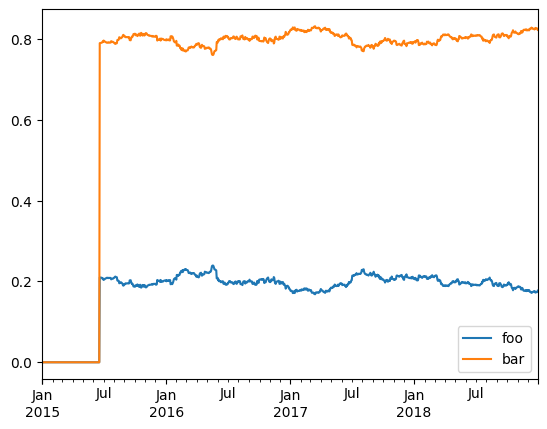

In [11]:
res_target.get_security_weights().plot();

<Axes: >

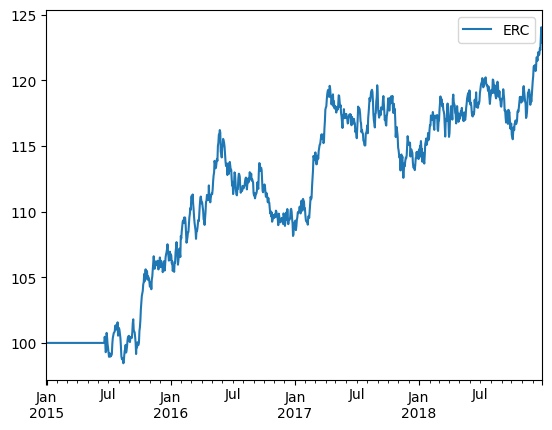

In [12]:
res_target.prices.plot()

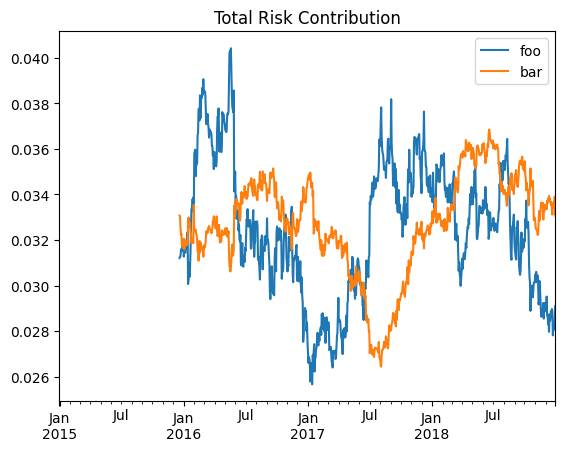

In [13]:
weights_target = res_target.get_security_weights().copy()
rolling_cov_target = (
    pdf.loc[:, weights_target.columns].pct_change().rolling(window=252).cov() * 252
)


trc_target = pd.DataFrame(
    np.nan, index=weights_target.index, columns=weights_target.columns
)

for dt in pdf.index:
    trc_target.loc[dt, :] = (
        weights_target.loc[dt, :].values
        * (rolling_cov_target.loc[dt, :].values @ weights_target.loc[dt, :].values)
        / np.sqrt(
            weights_target.loc[dt, :].values
            @ rolling_cov_target.loc[dt, :].values
            @ weights_target.loc[dt, :].values
        )
    )


fig, ax = plt.subplots(nrows=1, ncols=1)
trc_target.plot(ax=ax)
ax.set_title("Total Risk Contribution")
ax.plot();

You can see the Total Risk Contribution is roughly equal from both assets.